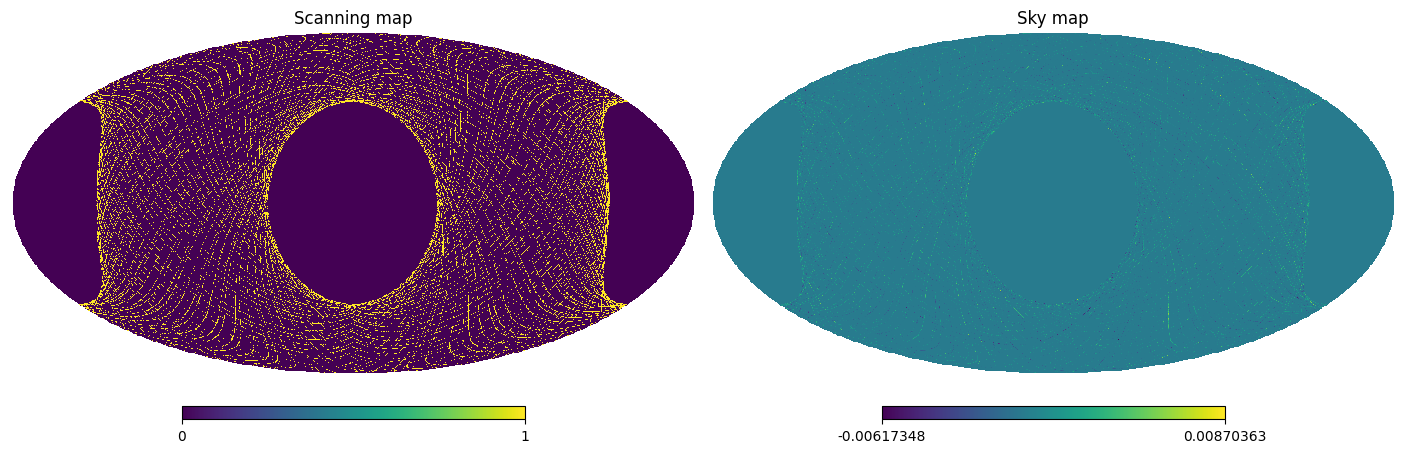

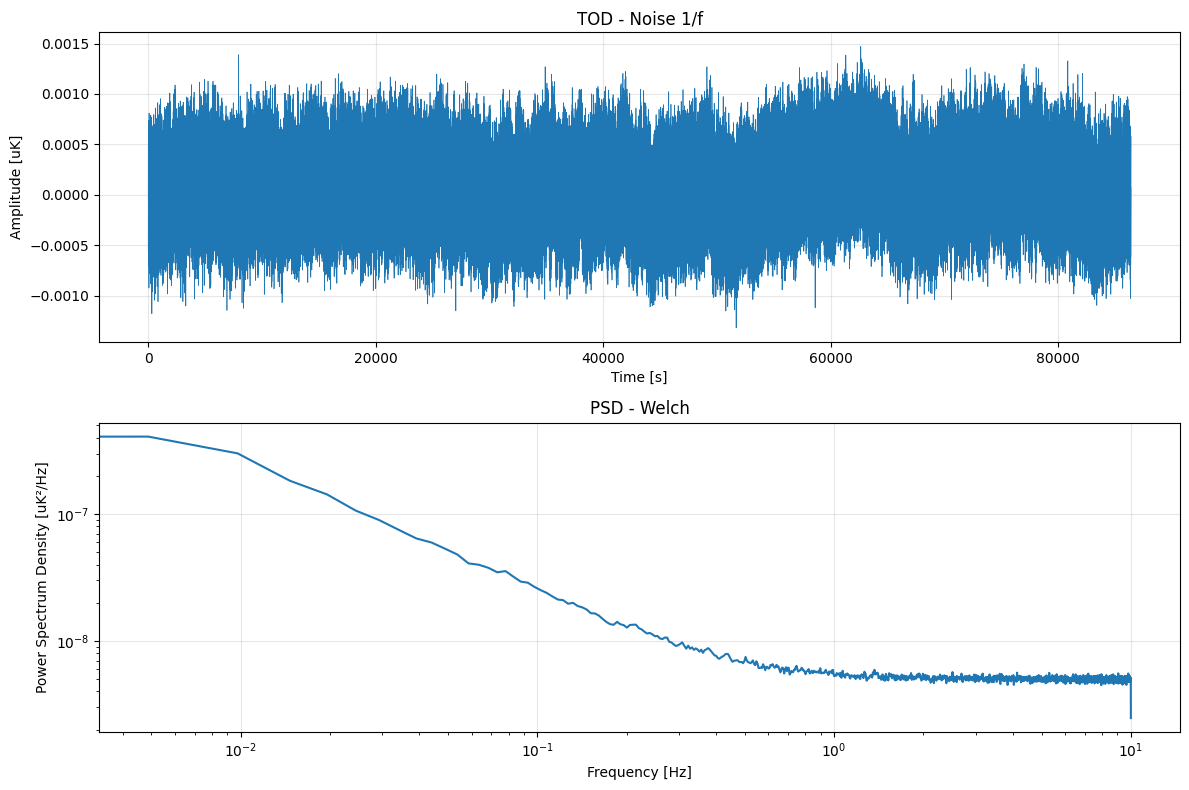

In [7]:
import sys, os
sys.path.append(os.path.abspath("../mylib_project"))

from mylib import add_OofaNoise

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from uuid import UUID

import litebird_sim as lbs



# SIMULATION

nside = 2**9 # map resolution
start_time = 0
duration_s = 86400. # one day

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=duration_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
)



# SCANNING STRATEGY (from IMO)

sim.set_scanning_strategy(
#    lbs.SpinningScanningStrategy(
#        spin_sun_angle_rad=np.deg2rad(0),
#        precession_rate_hz=0,
#        spin_rate_hz=1 / 60,   
#        start_time=start_time,
#    ),
    lbs.SpinningScanningStrategy.from_imo(imo=lbs.Imo(lbs.PTEP_IMO_LOCATION), url=UUID("117fd641-a925-4eeb-9fda-f7c468682108")),
    delta_time_s=5.0
)



# INSTRUMENT & DETECTOR

instrument = lbs.InstrumentInfo(
    boresight_rotangle_rad=0.0,
    spin_boresight_angle_rad=np.deg2rad(90),
    spin_rotangle_rad=np.deg2rad(75)
)
sim.set_instrument(instrument)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.0,
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.0,
    fmin_hz=1e-5,
    alpha=1
)



# OBSERVATION

sim.create_observations(detectors=det)
obs = sim.observations[0]



# POINTINGS

lbs.prepare_pointings(obs, instrument, sim.spin2ecliptic_quats)
pointings, _ = obs.get_pointings("all")

theta = pointings[0, :, 0]
phi   = pointings[0, :, 1]
pixidx = hp.ang2pix(nside, theta, phi)



# NOISE

tod = obs.tod                                   # shape (1, N)
add_OofaNoise(tod, det, block_duration_s=100)



# MAP

# Scanning map
m_scan = np.zeros(hp.nside2npix(nside))
m_scan[pixidx] = 1

# Noise map
m_noise = np.bincount(
    pixidx,
    weights=tod[0],
    minlength=hp.nside2npix(nside)
)



# PLOT HEALPIX MAP

plt.figure(figsize=(14, 6))

hp.mollview(m_scan, title="Scanning map", sub=(1,2,1))

hp.mollview(m_noise, title="Sky map", sub=(1,2,2))

plt.show()



# PSD WITH WELCH

frequencies, psd = welch(
    tod,                           # shape (1, N)
    fs=det.sampling_rate_hz,
    window='hann',
    nperseg=2**12,
    noverlap=2**12 // 2,
    scaling='density'
)



# PLOT TOD + PSD

plt.figure(figsize=(12, 8))

# --- TOD ---
plt.subplot(2, 1, 1)
time_axis = np.arange(tod.shape[1]) / det.sampling_rate_hz
plt.plot(time_axis, tod[0], linewidth=0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [uK]')
plt.title('TOD - Noise 1/f')
plt.grid(True, alpha=0.3)

# --- PSD with Welch ---
plt.subplot(2, 1, 2)
plt.loglog(frequencies, psd[0], linewidth=1.5)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectrum Density [uK²/Hz]')
plt.title('PSD - Welch')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
